In [1]:
from models.det_allhist_glm3 import Det_AllHist_GLM

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
eloc = np.load("/media/hdd01/sklee/CA1_clust4-60/data/Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy")
den_idx = np.unique(eloc[880:1120,0])

idx_raw = np.isin(eloc[:,0], den_idx)
idx = np.where(idx_raw == True)[0]
print(idx.size)

299


In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)[:,idx]
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

#####
V[V < 0.3] = 0

In [4]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 750
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 2500
epoch_no = 50
layer_no = 3

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = Det_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2653


In [ ]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, Z_pred, P_pred, out_filters = model(batch_E_neural, batch_I_neural)
        
    loss = torch.mean((V_pred - batch_V)**2)
    #loss = torch.var(V_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred, test_Z_pred, test_P_pred, test_out_filters = model(test_E_neural, test_I_neural) 
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_var = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_var, 6),
              np.round(test_mse, 6),
              torch.sum(test_Z_pred).item(),
             model.W_out.item(),
             model.Tau_out.item())


<ipython-input-7-9abb0e8d5fb6>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -68.858238 1.763214 3073.0 0.7199840545654297 -1.4321209192276



KeyboardInterrupt: 

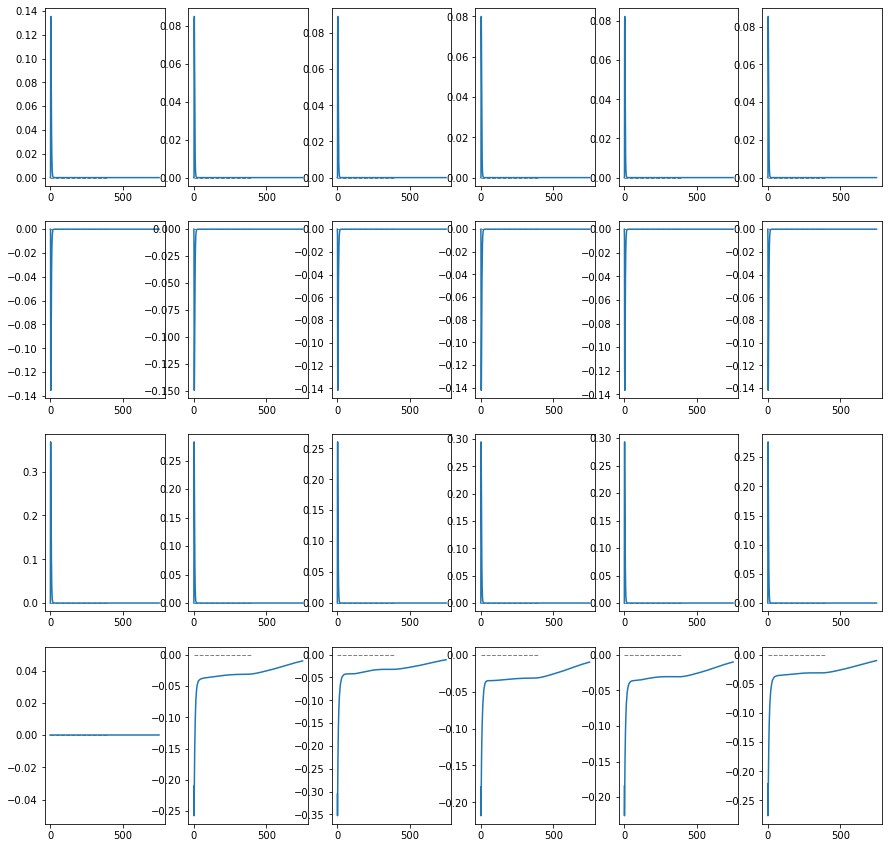

In [7]:
sub_no = 6
fig, axs = plt.subplots(nrows=4, ncols=sub_no, figsize=(15,15))
for row in range(4):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:750])
        axs[row,col].hlines(y=0,xmin=0,xmax=400, color="gray",linewidth=1,linestyle="--")

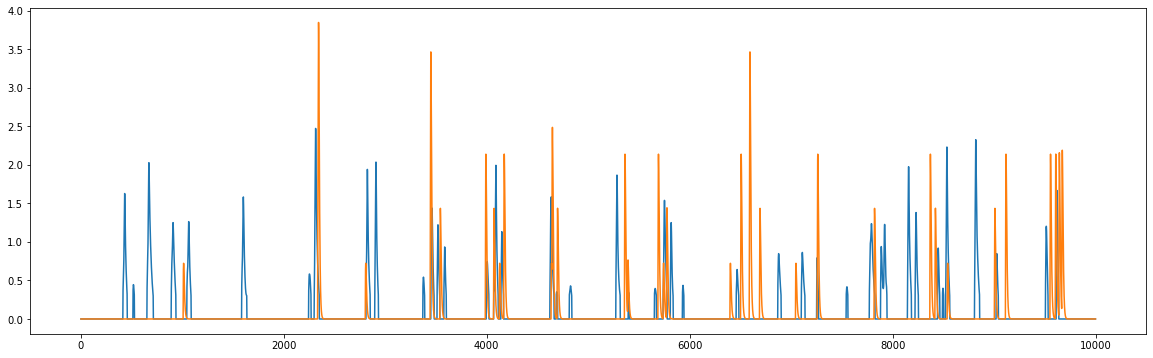

In [8]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])


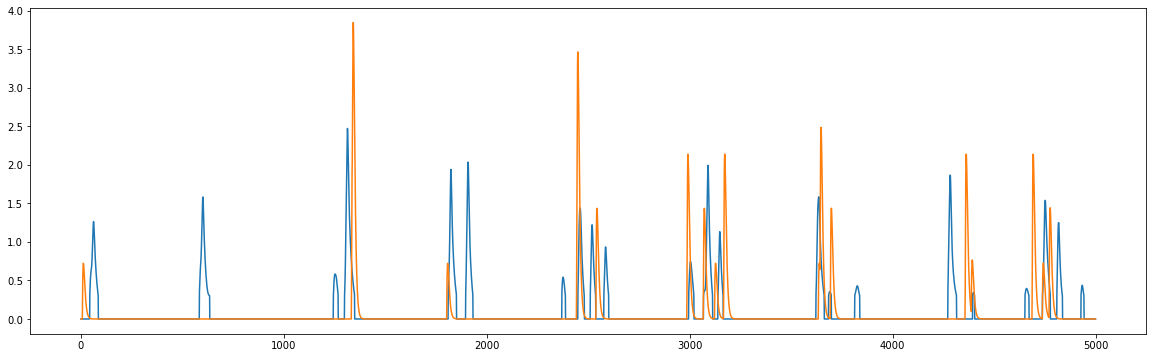

In [9]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][1000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][1000:6000])


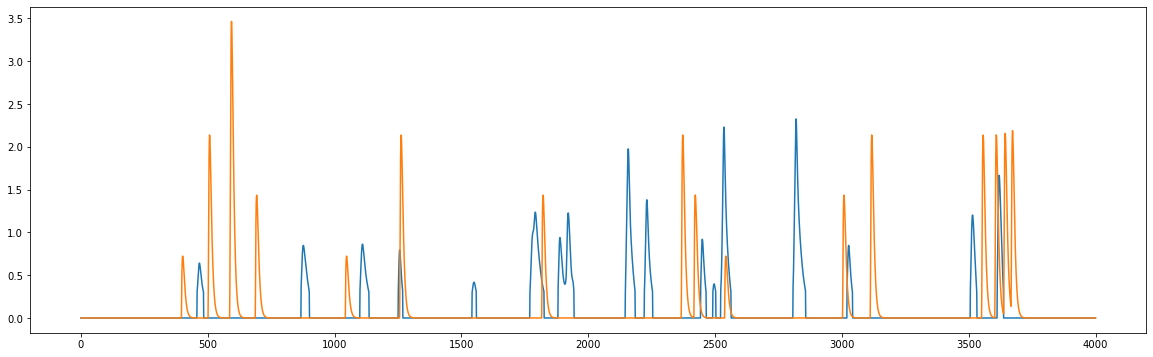

In [10]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][6000:10000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][6000:10000])


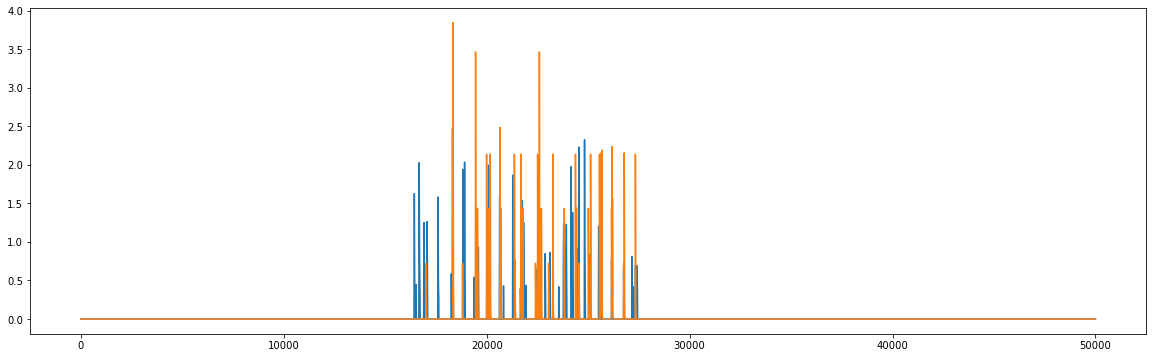

In [11]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[:])
plt.plot(test_V_pred.cpu().detach().numpy()[:])


In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Tau_syn tensor([[ 0.0000,  0.0000],
        [ 0.3048, -0.0964],
        [ 0.2535, -0.0561],
        [ 0.3341, -0.0590],
        [ 0.3236, -0.0149],
        [ 0.3178, -0.0503]], device='cuda:0')
Delta_syn tensor([[ 0.0000,  0.0000],
        [ 0.0007, -0.1070],
        [-0.0001, -0.0342],
        [-0.0012, -0.0783],
        [-0.0003, -0.0499],
        [-0.0007, -0.0688]], device='cuda:0')
W_syn tensor([[-1.0000, -1.0000],
        [-1.4550, -0.9026],
        [-1.4100, -0.9544],
        [-1.5148, -0.9503],
        [-1.4851, -0.9906],
        [-1.4487, -0.9522]], device='cuda:0')
Tau_spk tensor([0.0000, 0.2005, 0.2236, 0.1647, 0.1743, 0.2245], device='cuda:0')
W_spk tensor([ 0.0000, -0.2580, -0.3402, -0.2175, -0.2239, -0.2809], device='cuda:0')
W_hist tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [-0.1420, -0.1364, -0.1274, -0.1146, -0.0955, -0.0731,

In [14]:
out_raw = model.C_syn_e_raw.cpu().detach().numpy()
out = np.zeros((6,240))
out_idx = np.zeros((240))
for i in range(240):
    idx = np.argmax(out_raw[:,i])
    out[idx+1,i] = 1
    out_idx[i] = idx

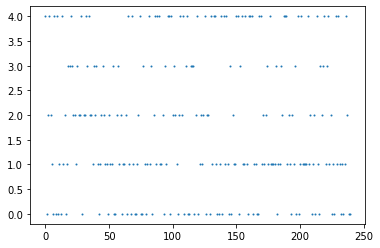

In [17]:
plt.scatter(np.arange(240),out_idx, s=1)